
# 量化交易策略实现与比较

本笔记本演示了多种交易策略的实现和性能对比。我们将探索：

- 移动平均线策略（单均线和双均线交叉）
- RSI超买超卖策略
- 布林带策略
- MACD策略
- 策略组合和绩效评估



## 导入必要的库和工具


In [1]:

# 基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

# 回测框架
import backtrader as bt

# 导入自定义策略
import sys
sys.path.append('..')
from strategies.moving_average import MovingAverageStrategy, MovingAverageCrossStrategy
from strategies.rsi import RSIStrategy
from strategies.bollinger_bands import BollingerBandsStrategy
from strategies.macd import MACDStrategy

# 设置绘图样式
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# 显示所有列
pd.set_option('display.max_columns', None)



## 获取市场数据

使用yfinance库获取回测用的历史数据：


In [2]:

# 定义回测的参数
ticker_symbol = 'SPY'  # 标普500ETF

start_date = '2023-02-28'
end_date = '2025-2-28'

# 获取数据
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
print(f"获取到{ticker_symbol}从{start_date}到{end_date}的数据，共{len(stock_data)}个交易日")
stock_data.head()


# 将 MultiIndex 列扁平化：取第一层作为新的列标签
stock_data.columns = stock_data.columns.get_level_values(0)
print("扁平化后的数据：")
print(stock_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

获取到SPY从2023-02-28到2025-2-28的数据，共502个交易日
扁平化后的数据：
Price            Close        High         Low        Open    Volume
Date                                                                
2023-02-28  385.384094  388.321195  385.277098  386.327472  96438600
2023-03-01  383.905823  385.802314  382.583164  384.557447  99706800
2023-03-02  386.891541  387.747392  381.561936  381.902336  85127800
2023-03-03  393.096436  393.349309  388.078055  388.739385  90120000
2023-03-06  393.368805  396.267026  392.921439  393.932873  72795900


In [3]:
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]



## 准备回测数据

将数据转换为Backtrader可用的格式：


In [4]:

# 将数据保存为CSV用于Backtrader
csv_file = f"{ticker_symbol}_data.csv"
stock_data.to_csv(csv_file)

# 辅助函数：创建Backtrader数据源
def create_bt_data_feed(csv_file):
    return bt.feeds.YahooFinanceCSVData(
        dataname=csv_file,
        fromdate=datetime.strptime(start_date, '%Y-%m-%d'),
        todate=datetime.strptime(end_date, '%Y-%m-%d'),
        reverse=False
    )
    
# 辅助函数：运行回测
def run_backtest(strategy_class, data_feed, cash=100000.0, commission=0.001, **strategy_params):
    # 创建Cerebro引擎
    cerebro = bt.Cerebro()
    
    # 添加数据
    cerebro.adddata(data_feed)
    
    # 添加策略
    cerebro.addstrategy(strategy_class, **strategy_params)
    
    # 设置初始资金和佣金
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)
    
    # 添加分析器
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    # 运行策略
    initial_value = cerebro.broker.getvalue()
    print(f'初始资金: ${initial_value:.2f}')
    
    results = cerebro.run()
    strategy = results[0]
    
    # 获取最终资金
    final_value = cerebro.broker.getvalue()
    print(f'最终资金: ${final_value:.2f}')
    print(f'盈亏: ${final_value - initial_value:.2f} ({(final_value / initial_value - 1) * 100:.2f}%)')
    
    # 分析结果
    print('\n--- 性能指标 ---')
    print(f'夏普比率: {strategy.analyzers.sharpe.get_analysis()["sharperatio"]:.4f}')
    print(f'最大回撤: {strategy.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')
    print(f'年化收益率: {strategy.analyzers.returns.get_analysis()["rnorm100"]:.2f}%')
    
    return cerebro, strategy, results



## 移动平均线交叉策略回测

实现并回测移动平均线策略：


In [5]:
class MovingAverageCrossStrategy(bt.Strategy):
    """
    短期均线(SMA_Fast)上穿长期均线(SMA_Slow) => 全仓买入
    下穿 => 卖出全部
    """
    params = (
        ('fast_period', 20),
        ('slow_period', 50),
        ('printlog', True),
    )
    
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        self.order = None
        
        # 移动平均线
        self.fast_ma = bt.indicators.SimpleMovingAverage(
            self.datas[0].close, period=self.params.fast_period
        )
        self.slow_ma = bt.indicators.SimpleMovingAverage(
            self.datas[0].close, period=self.params.slow_period
        )
        
        # 交叉信号
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'买单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
            else:
                self.log(f'卖单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消/拒绝')
        
        self.order = None
    
    def next(self):
        if self.order:
            return
        
        # 若无持仓，且短期MA上穿长期MA => 全仓买入
        if not self.position:
            if self.crossover > 0:
                cash = self.broker.getcash()
                price = self.datas[0].close[0]
                size = int(cash // price)
                if size > 0:
                    self.log(f'买入信号 (fast_ma>slow_ma), 全仓买入: {size} 股')
                    self.order = self.buy(size=size)
        else:
            # 若已持仓，且短期MA下穿长期MA => 卖出全部
            if self.crossover < 0:
                self.log(f'卖出信号 (fast_ma<slow_ma), 卖出全部: {self.position.size} 股')
                self.order = self.sell(size=self.position.size)
    
    def stop(self):
        self.log(f'策略结束，期末资金: {self.broker.getvalue():.2f}')


In [6]:

# ---------------------------
# 3. 配置并运行回测
# ---------------------------

# 创建 Cerebro 回测引擎
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)  # 设置初始资金

# 将策略加入引擎，同时打开日志便于调试（printlog=True）
cerebro.addstrategy(MovingAverageCrossStrategy, fast_period=20, slow_period=50, printlog=True)

# 创建数据源并添加到 Cerebro
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# 输出初始资金
print('初始资金: %.2f' % cerebro.broker.getvalue())

# 运行回测
cerebro.run()

# 输出最终资金
print('期末资金: %.2f' % cerebro.broker.getvalue())

# ---------------------------
# 4. 绘制回测结果图
# ---------------------------
%matplotlib inline
cerebro.plot(style='candlestick',iplot = False)

初始资金: 100000.00
2023-11-20, 买入信号 (fast_ma>slow_ma), 全仓买入: 223 股
2023-11-21, 买单执行, 价格: 445.63, 股数: 223
2024-04-26, 卖出信号 (fast_ma<slow_ma), 卖出全部: 223 股
2024-04-29, 卖单执行, 价格: 505.19, 股数: -223
2024-05-20, 买入信号 (fast_ma>slow_ma), 全仓买入: 215 股
2024-05-21, 买单执行, 价格: 524.20, 股数: 215
2024-08-09, 卖出信号 (fast_ma<slow_ma), 卖出全部: 215 股
2024-08-12, 卖单执行, 价格: 530.79, 股数: -215
2024-09-03, 买入信号 (fast_ma>slow_ma), 全仓买入: 209 股
2024-09-04, 买单执行, 价格: 546.68, 股数: 209
2025-01-14, 卖出信号 (fast_ma<slow_ma), 卖出全部: 209 股
2025-01-15, 卖单执行, 价格: 590.33, 股数: -209
2025-02-04, 买入信号 (fast_ma>slow_ma), 全仓买入: 205 股
2025-02-05, 买单执行, 价格: 600.64, 股数: 205
2025-02-27, 策略结束，期末资金: 120626.22
期末资金: 120626.22


[[<Figure size 2800x1400 with 5 Axes>]]


## RSI策略回测

实现并回测基于RSI的交易策略：


In [7]:
class RSIStrategy(bt.Strategy):
    """
    - 当 RSI < 30 => 全仓买入
    - 当 RSI > 70 => 卖出全部
    """
    params = (
        ('rsi_period', 14),
        ('rsi_low', 30),
        ('rsi_high', 70),
        ('printlog', True),
    )
    
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        self.order = None
        self.rsi = bt.indicators.RSI_SMA(self.datas[0], period=self.params.rsi_period)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'买单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
            else:
                self.log(f'卖单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消/拒绝')
        self.order = None
    
    def next(self):
        price = self.datas[0].close[0]
        rsi_value = self.rsi[0]
        self.log(f'收盘价: {price:.2f}, RSI: {rsi_value:.2f}')
        
        if self.order:
            return
        
        # 若无持仓，且 RSI < 30 => 全仓买入
        if not self.position:
            if rsi_value < self.params.rsi_low:
                cash = self.broker.getcash()
                size = int(cash // price)
                if size > 0:
                    self.log(f'买入信号 (RSI<{self.params.rsi_low}), 全仓买入: {size} 股')
                    self.order = self.buy(size=size)
        else:
            # 有持仓时，若 RSI > 70 => 卖出全部
            if rsi_value > self.params.rsi_high:
                self.log(f'卖出信号 (RSI>{self.params.rsi_high}), 卖出全部: {self.position.size} 股')
                self.order = self.sell(size=self.position.size)
    
    def stop(self):
        self.log(f'策略结束，期末资金: {self.broker.getvalue():.2f}')

In [8]:
# ---------------------------
# 3. 创建并运行回测引擎
# ---------------------------

# 创建 Cerebro 引擎
cerebro = bt.Cerebro()

# 设置初始资金
cerebro.broker.setcash(100000.0)

# 添加数据源
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# 添加策略
cerebro.addstrategy(RSIStrategy, rsi_period=14, rsi_low=30, rsi_high=70, printlog=True)

# 打印初始资金
print(f'初始资金: {cerebro.broker.getvalue():.2f}')

# 运行回测
results = cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'回测结束，期末资金: {final_value:.2f}')

初始资金: 100000.00
2023-03-20, 收盘价: 384.39, RSI: 49.09
2023-03-21, 收盘价: 389.44, RSI: 54.79
2023-03-22, 收盘价: 382.80, RSI: 46.67
2023-03-23, 收盘价: 383.84, RSI: 41.77
2023-03-24, 收盘价: 386.36, RSI: 44.00
2023-03-27, 收盘价: 387.08, RSI: 49.76
2023-03-28, 收盘价: 386.21, RSI: 48.35
2023-03-29, 收盘价: 391.82, RSI: 60.62
2023-03-30, 收盘价: 394.12, RSI: 69.32
2023-03-31, 收盘价: 399.67, RSI: 73.18
2023-04-03, 收盘价: 401.20, RSI: 70.63
2023-04-04, 收盘价: 398.97, RSI: 70.85
2023-04-05, 收盘价: 397.93, RSI: 64.67
2023-04-06, 收盘价: 399.48, RSI: 73.26
2023-04-10, 收盘价: 399.89, RSI: 70.91
2023-04-11, 收盘价: 400.00, RSI: 66.43
2023-04-12, 收盘价: 398.37, RSI: 78.71
2023-04-13, 收盘价: 403.66, RSI: 81.60
2023-04-14, 收盘价: 402.67, RSI: 77.35
2023-04-17, 收盘价: 404.12, RSI: 77.88
2023-04-18, 收盘价: 404.38, RSI: 80.34
2023-04-19, 收盘价: 404.31, RSI: 75.59
2023-04-20, 收盘价: 402.10, RSI: 66.43
2023-04-21, 收盘价: 402.42, RSI: 57.19
2023-04-24, 收盘价: 402.84, RSI: 54.57
2023-04-25, 收盘价: 396.44, RSI: 44.29
2023-04-26, 收盘价: 394.76, RSI: 43.05
2023-04-27, 

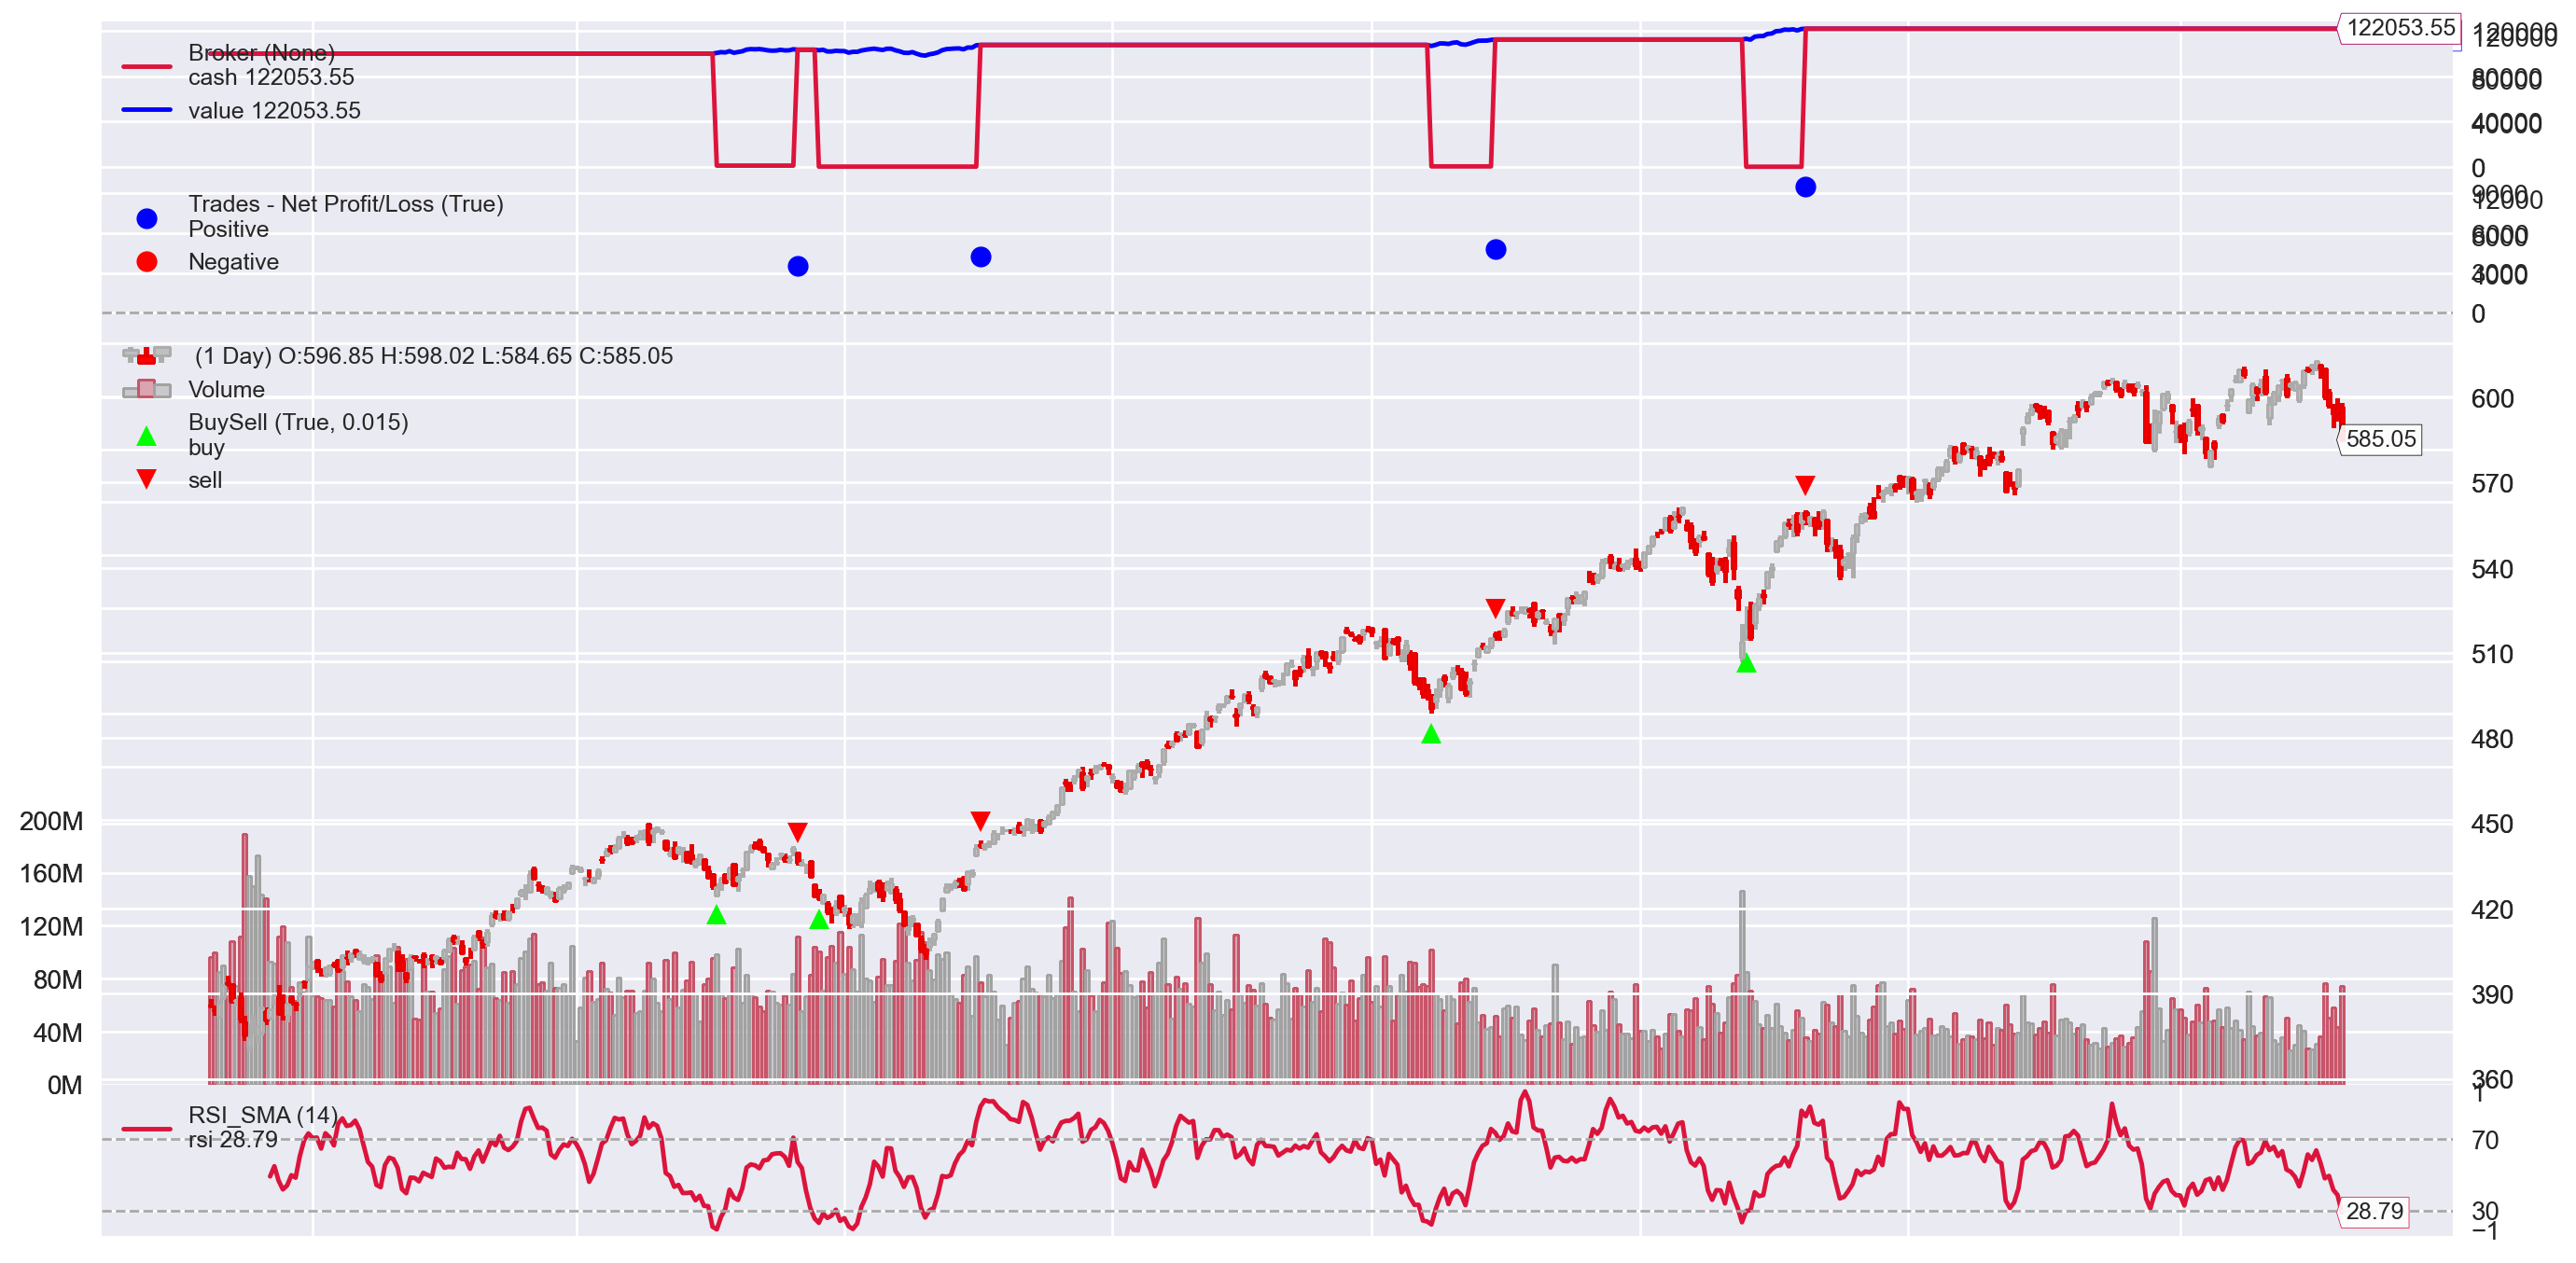

[[<Figure size 2800x1400 with 10 Axes>]]

In [9]:
%matplotlib inline
cerebro.plot(style='candlestick', iplot=False)


## 布林带策略回测

实现并回测基于布林带的交易策略：


In [10]:
# ---------------------------
# 2. 定义布林带策略（全仓进出）
# ---------------------------
class BollingerBandsStrategy(bt.Strategy):
    """
    简单布林带均值回归:
    - 收盘价 < 下轨 => 全仓买入
    - 收盘价 > 上轨 => 全部卖出
    """
    params = (
        ('period', 20),
        ('devfactor', 2.0),
        ('printlog', True),
    )
    
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        self.order = None
        self.boll = bt.indicators.BollingerBands(
            self.datas[0],
            period=self.params.period,
            devfactor=self.params.devfactor
        )
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'买单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
            else:
                self.log(f'卖单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消/拒绝')
        
        self.order = None
    
    def next(self):
        close_price = self.datas[0].close[0]
        top = self.boll.top[0]
        bot = self.boll.bot[0]
        
        self.log(f'收盘价: {close_price:.2f}, 上轨: {top:.2f}, 下轨: {bot:.2f}')
        
        if self.order:
            return
        
        if not self.position:
            # 跌破下轨 => 全仓买入
            if close_price < bot:
                cash = self.broker.getcash()
                size = int(cash // close_price)
                if size > 0:
                    self.log(f'买入信号 (收盘价<下轨), 全仓买入: {size} 股')
                    self.order = self.buy(size=size)
        else:
            # 突破上轨 => 全部卖出
            if close_price > top:
                self.log(f'卖出信号 (收盘价>上轨), 卖出全部: {self.position.size} 股')
                self.order = self.sell(size=self.position.size)
    
    def stop(self):
        self.log(f'策略结束，期末资金: {self.broker.getvalue():.2f}')

# ---------------------------
# 3. 定义自定义 Analyzer 用于记录资金曲线
# ---------------------------
class EquityCurveAnalyzer(bt.Analyzer):
    def start(self):
        self.equity = []
        self.dates = []
    
    def next(self):
        # 每个bar记录一次资金量
        self.equity.append(self.strategy.broker.getvalue())
        # 将 datetime 转换为日期对象
        dt = self.strategy.datas[0].datetime.date(0)
        self.dates.append(dt)
    
    def get_analysis(self):
        return {'dates': self.dates, 'equity': self.equity}

# ---------------------------
# 4. 创建并运行回测引擎
# ---------------------------
cerebro = bt.Cerebro()

# 设置初始资金
cerebro.broker.setcash(100000.0)

# 添加数据源
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# 添加策略
cerebro.addstrategy(
    BollingerBandsStrategy,
    period=20,      # 布林带周期
    devfactor=2.0,  # 标准差倍数
    printlog=True
)

# 添加资金曲线 Analyzer
cerebro.addanalyzer(EquityCurveAnalyzer, _name='equitycurve')

# 打印初始资金
print(f'初始资金: {cerebro.broker.getvalue():.2f}')

# 运行回测
results = cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'回测结束，期末资金: {final_value:.2f}')

# 获取资金曲线数据
equity_analyzer = results[0].analyzers.equitycurve.get_analysis()
dates = equity_analyzer['dates']
equity = equity_analyzer['equity']

初始资金: 100000.00
2023-03-27, 收盘价: 387.08, 上轨: 394.13, 下轨: 374.71
2023-03-28, 收盘价: 386.21, 上轨: 394.19, 下轨: 374.72
2023-03-29, 收盘价: 391.82, 上轨: 395.10, 下轨: 374.61
2023-03-30, 收盘价: 394.12, 上轨: 396.20, 下轨: 374.23
2023-03-31, 收盘价: 399.67, 上轨: 397.78, 下轨: 373.31
2023-04-03, 收盘价: 401.20, 上轨: 399.57, 下轨: 372.30
2023-04-04, 收盘价: 398.97, 上轨: 401.28, 下轨: 371.75
2023-04-05, 收盘价: 397.93, 上轨: 402.59, 下轨: 371.44
2023-04-06, 收盘价: 399.48, 上轨: 404.15, 下轨: 371.74
2023-04-10, 收盘价: 399.89, 上轨: 405.09, 下轨: 373.27
2023-04-11, 收盘价: 400.00, 上轨: 405.56, 下轨: 375.31
2023-04-12, 收盘价: 398.37, 上轨: 406.15, 下轨: 376.46
2023-04-13, 收盘价: 403.66, 上轨: 407.13, 下轨: 377.99
2023-04-14, 收盘价: 402.67, 上轨: 408.23, 下轨: 378.63
2023-04-17, 收盘价: 404.12, 上轨: 408.89, 下轨: 380.31
2023-04-18, 收盘价: 404.38, 上轨: 409.69, 下轨: 381.51
2023-04-19, 收盘价: 404.31, 上轨: 410.62, 下轨: 382.07
2023-04-20, 收盘价: 402.10, 上轨: 410.35, 下轨: 384.27
2023-04-21, 收盘价: 402.42, 上轨: 409.88, 下轨: 386.59
2023-04-24, 收盘价: 402.84, 上轨: 409.49, 下轨: 388.63
2023-04-25, 收盘价: 396.44,

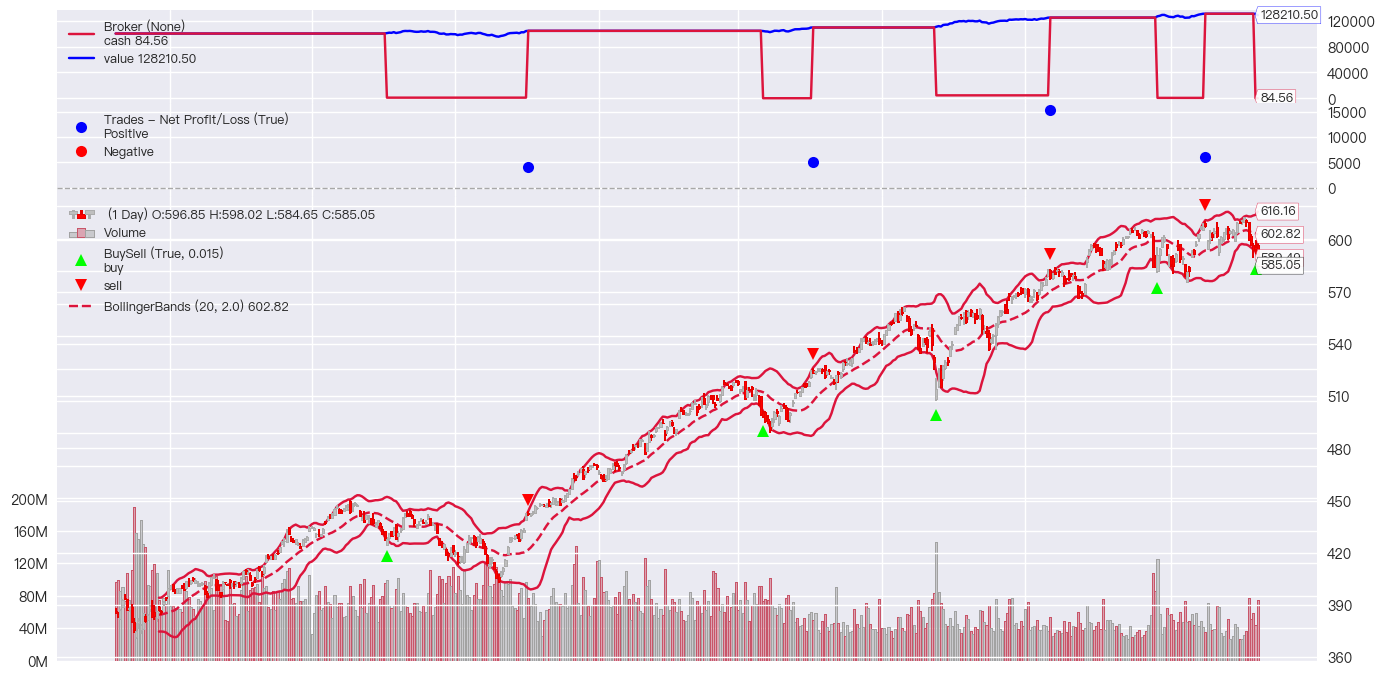

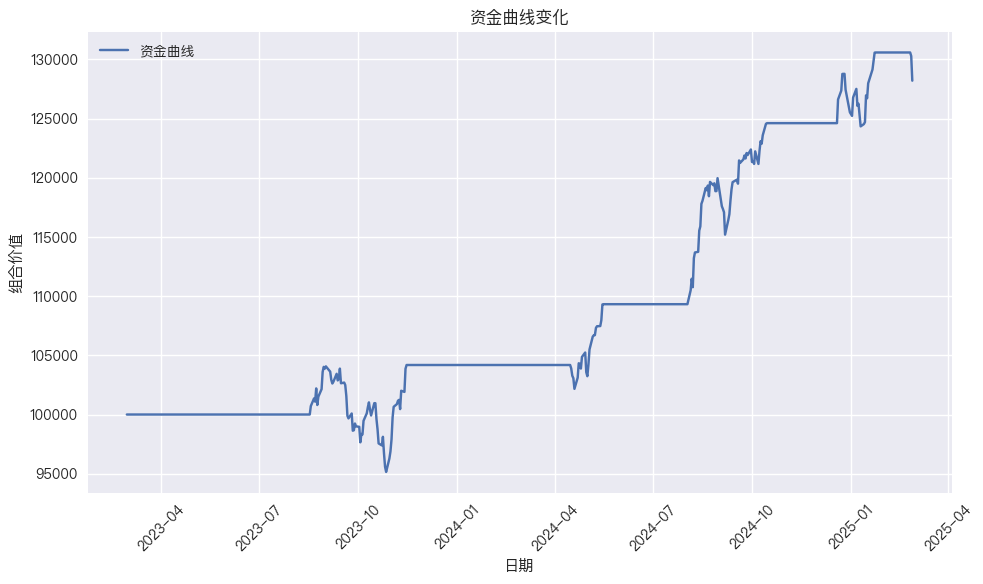

In [11]:
# ---------------------------
# 5. 绘制回测结果及资金曲线
# ---------------------------
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False


# 使用 Backtrader 内置绘图
%matplotlib inline
cerebro.plot(style='candlestick', iplot=False)

# 绘制资金曲线
plt.figure(figsize=(10,6))
plt.plot(dates, equity, label='资金曲线')
plt.xlabel('日期')
plt.ylabel('组合价值')
plt.title('资金曲线变化')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# from IPython.display import display

# figs = cerebro.plot(style='candlestick')
# # cerebro.plot() 返回的是一个嵌套列表
# for fig in figs[0]:
#     display(fig)



## MACD策略回测

实现并回测基于MACD的趋势跟踪策略：


In [12]:
# ---------------------------
# 2. 定义 MACD 策略 (全仓进出)
# ---------------------------
class MACDStrategy(bt.Strategy):
    """
    简单的 MACD 策略:
    - 当 MACD 线上穿信号线 => 全仓买入
    - 当 MACD 线下穿信号线 => 卖出全部
    """
    params = (
        ('fastperiod', 12),      # MACD 快线 EMA 周期
        ('slowperiod', 26),      # MACD 慢线 EMA 周期
        ('signalperiod', 9),     # 信号线 EMA 周期
        ('printlog', True),      # 是否打印日志
    )
    
    def log(self, txt, dt=None):
        """日志记录函数"""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        self.order = None
        
        # 在 Backtrader 中，MACD 指标会有 macd, signal, hist 三条线
        self.macd_ind = bt.indicators.MACD(
            self.datas[0].close,
            period_me1=self.p.fastperiod,
            period_me2=self.p.slowperiod,
            period_signal=self.p.signalperiod
        )
        
        # 我们只需要判断 MACD 线 (macd) 与 信号线 (signal) 的交叉
        # >0 表示 macd 上穿 signal, <0 表示 macd 下穿 signal
        self.macd_crossover = bt.indicators.CrossOver(self.macd_ind.macd, self.macd_ind.signal)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'买单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
            else:
                self.log(f'卖单执行, 价格: {order.executed.price:.2f}, 股数: {order.executed.size}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消/拒绝')
        
        self.order = None
    
    def next(self):
        # 如果有订单在执行，则不再继续下单
        if self.order:
            return
        
        # 若无持仓且 MACD 线上穿信号线 => 全仓买入
        if not self.position:
            if self.macd_crossover > 0:
                cash = self.broker.getcash()
                price = self.datas[0].close[0]
                size = int(cash // price)
                if size > 0:
                    self.log(f'买入信号 (MACD>Signal), 全仓买入: {size} 股, 当前收盘价: {price:.2f}')
                    self.order = self.buy(size=size)
        else:
            # 若已持仓且 MACD 线下穿信号线 => 卖出全部
            if self.macd_crossover < 0:
                self.log(f'卖出信号 (MACD<Signal), 卖出全部: {self.position.size} 股')
                self.order = self.sell(size=self.position.size)
    
    def stop(self):
        """策略结束时输出最终资金"""
        self.log(f'策略结束，期末资金: {self.broker.getvalue():.2f}')

初始资金: 100000.00
2023-05-18, 买入信号 (MACD>Signal), 全仓买入: 244 股, 当前收盘价: 409.28
2023-05-19, 订单取消/拒绝
2023-05-26, 买入信号 (MACD>Signal), 全仓买入: 243 股, 当前收盘价: 410.05
2023-05-30, 订单取消/拒绝
2023-07-03, 买入信号 (MACD>Signal), 全仓买入: 229 股, 当前收盘价: 434.87
2023-07-05, 买单执行, 价格: 433.02, 股数: 229
2023-07-06, 卖出信号 (MACD<Signal), 卖出全部: 229 股
2023-07-07, 卖单执行, 价格: 429.81, 股数: -229
2023-07-13, 买入信号 (MACD>Signal), 全仓买入: 225 股, 当前收盘价: 440.52
2023-07-14, 订单取消/拒绝
2023-08-29, 买入信号 (MACD>Signal), 全仓买入: 225 股, 当前收盘价: 440.13
2023-08-30, 买单执行, 价格: 440.47, 股数: 225
2023-09-18, 卖出信号 (MACD<Signal), 卖出全部: 225 股
2023-09-19, 卖单执行, 价格: 435.31, 股数: -225
2023-10-09, 买入信号 (MACD>Signal), 全仓买入: 230 股, 当前收盘价: 425.09
2023-10-10, 买单执行, 价格: 425.73, 股数: 230
2023-10-20, 卖出信号 (MACD<Signal), 卖出全部: 230 股
2023-10-23, 卖单执行, 价格: 412.62, 股数: -230
2023-11-02, 买入信号 (MACD>Signal), 全仓买入: 224 股, 当前收盘价: 423.59
2023-11-03, 订单取消/拒绝
2023-12-12, 买入信号 (MACD>Signal), 全仓买入: 208 股, 当前收盘价: 456.37
2023-12-13, 买单执行, 价格: 456.76, 股数: 208
2023-12-29, 卖出信号 (MACD<Signal),

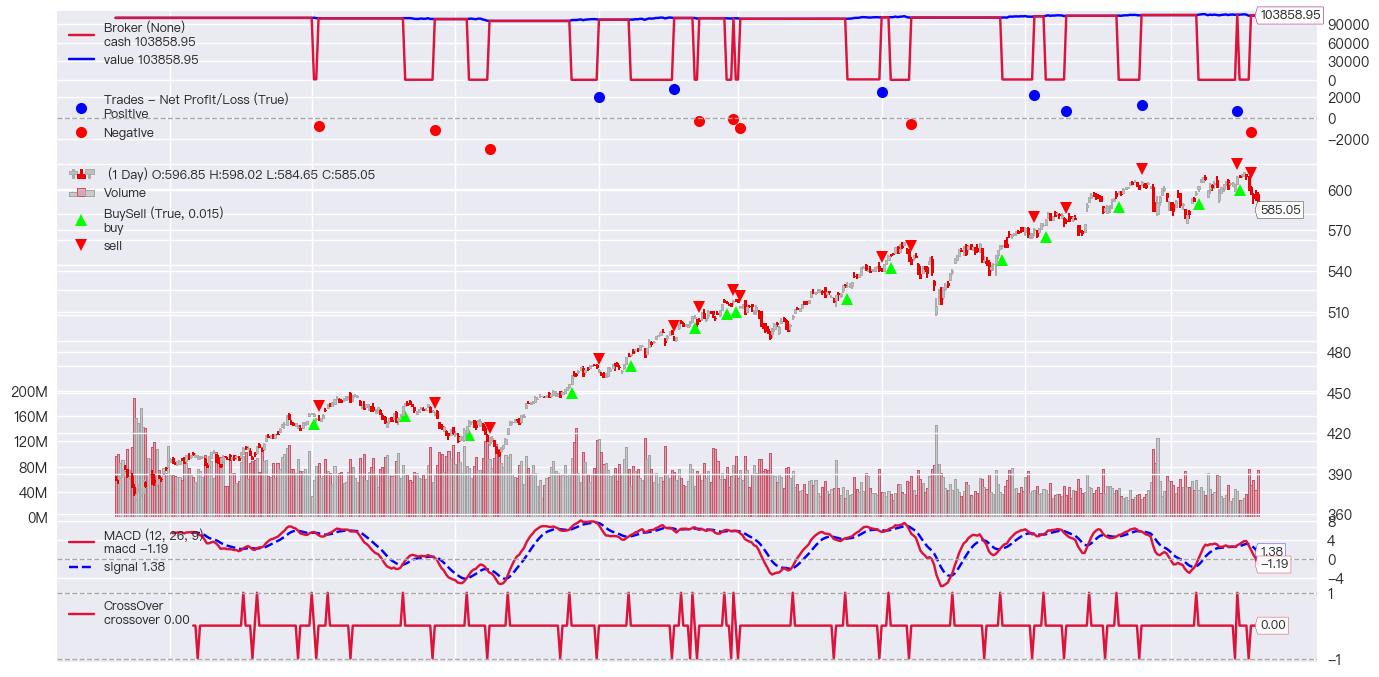

[[<Figure size 1400x700 with 6 Axes>]]

In [13]:

# ---------------------------
# 3. 创建并运行回测引擎
# ---------------------------
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)

data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# 添加 MACD 策略
cerebro.addstrategy(MACDStrategy,
                    fastperiod=12,
                    slowperiod=26,
                    signalperiod=9,
                    printlog=True)

print(f'初始资金: {cerebro.broker.getvalue():.2f}')
cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'回测结束，期末资金: {final_value:.2f}')

# 绘制回测结果
%matplotlib inline
cerebro.plot(style='candlestick',iplot=False)



## Buy & Hold 策略回测

实现并回测Buy & Hold策略：


In [14]:
class BuyHoldStrategy(bt.Strategy):
    params = (
        ('printlog', True),
    )
    
    def log(self, txt, dt=None):
        """日志记录函数"""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        # 用于跟踪订单状态
        self.order = None

    def next(self):
        if not self.position:  # 没有持仓时
            # 当前现金
            cash = self.broker.getcash()
            # 当前收盘价
            price = self.datas[0].close[0]
            # 计算可买股数（整股）
            size = int(cash // price)  # 使用整除保证是整数
            
            if size > 0:
                self.order = self.buy(size=size)  # 买入 size 股

    
    def notify_order(self, order):
        """订单通知函数"""
        if order.status in [order.Submitted, order.Accepted]:
            return  # 等待执行
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'买入订单执行，价格: {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'卖出订单执行，价格: {order.executed.price:.2f}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单被取消/拒绝')
        
        # 重置订单引用
        self.order = None
    
    def stop(self):
        """策略结束时记录期末资金"""
        self.log(f'策略结束，期末资金: {self.broker.getvalue():.2f}')

初始资金: 100000.00
2023-03-01, 买入订单执行，价格: 384.56
2025-02-27, 策略结束，期末资金: 151927.57
期末资金: 151927.57


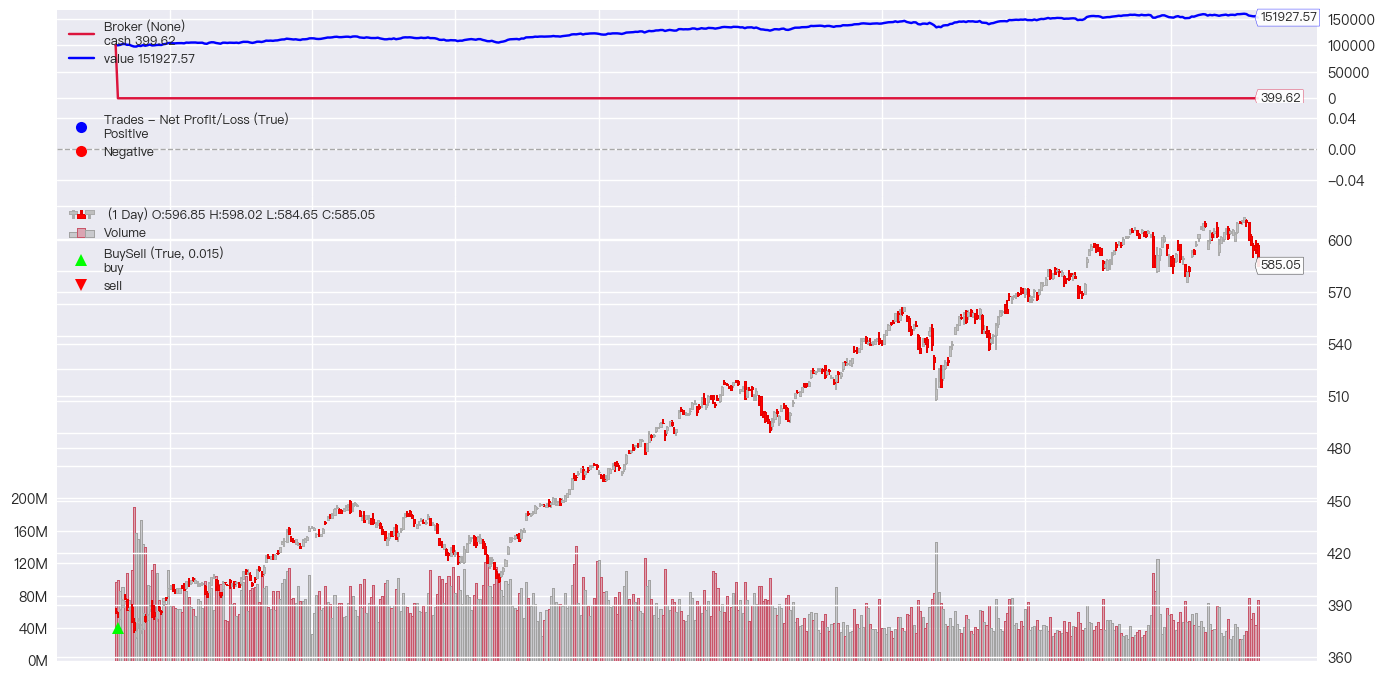

[[<Figure size 1400x700 with 4 Axes>]]

In [15]:

# ---------------------------
# 3. 创建并运行回测引擎
# ---------------------------

cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)  # 设置初始资金

# 添加数据
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# 添加 Buy & Hold 策略
cerebro.addstrategy(BuyHoldStrategy, printlog=True)

print(f'初始资金: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'期末资金: {final_value:.2f}')

# ---------------------------
# 4. 绘制回测结果
# ---------------------------
%matplotlib inline
cerebro.plot(style='candlestick', iplot=False)



## 策略性能比较

比较不同策略的性能指标：


In [16]:
# ---------------------------
# 2. 定义通用回测函数，运行策略并提取绩效指标
# ---------------------------
def run_strategy_and_get_metrics(strategy_class, data_feed, cash=100000.0, commission=0.0, **strategy_params):
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)
    cerebro.adddata(data_feed)
    cerebro.addstrategy(strategy_class, **strategy_params)
    
    # 添加常见的分析器
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns', tann=252)
    
    results = cerebro.run()
    strat = results[0]
    
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', None)
    drawdown = strat.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', None)
    annual_return = strat.analyzers.returns.get_analysis().get('rnorm100', None)
    
    metrics = {
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': drawdown,
        'Annual Return (%)': annual_return
    }
    return metrics

# ---------------------------
# 4. 定义要比较的策略及其参数
# ---------------------------
strategy_configs = [
    ('MA Cross', MovingAverageCrossStrategy, dict(fast_period=20, slow_period=50)),
    ('RSI', RSIStrategy, dict(rsi_period=14, rsi_low=30, rsi_high=70)),
    ('Bollinger Bands', BollingerBandsStrategy, dict(period=20, devfactor=2.0)),
    ('MACD', MACDStrategy, dict(fastperiod=12, slowperiod=26, signalperiod=9)),
]

results_dict = {}
for name, strat_class, params in strategy_configs:
    metrics = run_strategy_and_get_metrics(strat_class, data_feed, cash=100000.0, commission=0.0, **params)
    results_dict[name] = metrics

performance_df = pd.DataFrame.from_dict(results_dict, orient='index')
performance_df = performance_df.sort_values('Annual Return (%)', ascending=False)

print("策略绩效对比：")
print(performance_df)

2023-11-20, 买入信号 (fast_ma>slow_ma), 全仓买入: 223 股
2023-11-21, 买单执行, 价格: 445.63, 股数: 223
2024-04-26, 卖出信号 (fast_ma<slow_ma), 卖出全部: 223 股
2024-04-29, 卖单执行, 价格: 505.19, 股数: -223
2024-05-20, 买入信号 (fast_ma>slow_ma), 全仓买入: 215 股
2024-05-21, 买单执行, 价格: 524.20, 股数: 215
2024-08-09, 卖出信号 (fast_ma<slow_ma), 卖出全部: 215 股
2024-08-12, 卖单执行, 价格: 530.79, 股数: -215
2024-09-03, 买入信号 (fast_ma>slow_ma), 全仓买入: 209 股
2024-09-04, 买单执行, 价格: 546.68, 股数: 209
2025-01-14, 卖出信号 (fast_ma<slow_ma), 卖出全部: 209 股
2025-01-15, 卖单执行, 价格: 590.33, 股数: -209
2025-02-04, 买入信号 (fast_ma>slow_ma), 全仓买入: 205 股
2025-02-05, 买单执行, 价格: 600.64, 股数: 205
2025-02-27, 策略结束，期末资金: 120626.22
2023-03-20, 收盘价: 384.39, RSI: 49.09
2023-03-21, 收盘价: 389.44, RSI: 54.79
2023-03-22, 收盘价: 382.80, RSI: 46.67
2023-03-23, 收盘价: 383.84, RSI: 41.77
2023-03-24, 收盘价: 386.36, RSI: 44.00
2023-03-27, 收盘价: 387.08, RSI: 49.76
2023-03-28, 收盘价: 386.21, RSI: 48.35
2023-03-29, 收盘价: 391.82, RSI: 60.62
2023-03-30, 收盘价: 394.12, RSI: 69.32
2023-03-31, 收盘价: 399.67, RSI: 73.18
20

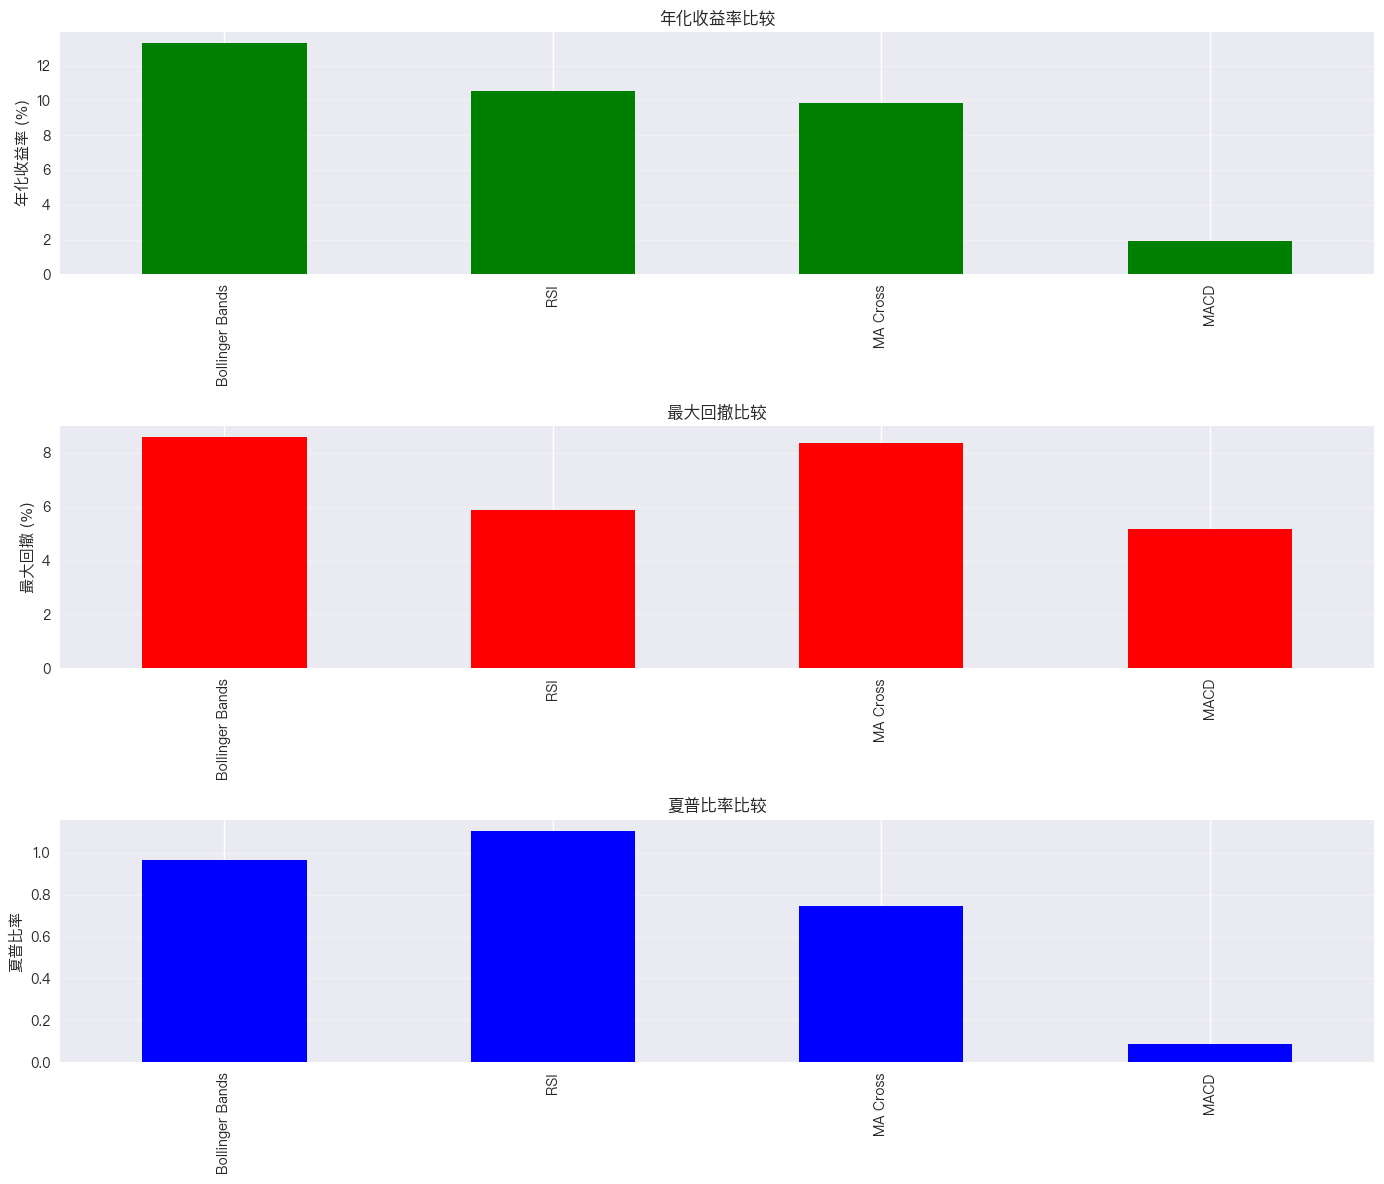

In [17]:

# ---------------------------
# 5. 可视化绩效比较
# ---------------------------
%matplotlib inline
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
performance_df['Annual Return (%)'].plot(kind='bar', color='green')
plt.title('年化收益率比较')
plt.ylabel('年化收益率 (%)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 1, 2)
performance_df['Max Drawdown (%)'].plot(kind='bar', color='red')
plt.title('最大回撤比较')
plt.ylabel('最大回撤 (%)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 1, 3)
performance_df['Sharpe Ratio'].plot(kind='bar', color='blue')
plt.title('夏普比率比较')
plt.ylabel('夏普比率')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



## 策略参数优化

优化表现最好的策略的参数：


In [ ]:

# 假设我们要优化移动平均线交叉策略的参数

# 定义要优化的参数范围
fast_periods = range(5, 30, 5)  # 5, 10, 15, 20, 25
slow_periods = range(30, 100, 10)  # 30, 40, 50, 60, 70, 80, 90

# 存储优化结果
optimization_results = []

# 创建Cerebro引擎
cerebro = bt.Cerebro(optreturn=False)

# 添加数据
cerebro.adddata(create_bt_data_feed(csv_file))

# 添加策略进行优化
cerebro.optstrategy(
    MovingAverageCrossStrategy,
    fast_period=fast_periods,
    slow_period=slow_periods,
    ma_type='SMA'
)

# 设置初始资金和佣金
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

# 添加分析器
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# 运行优化
print("正在优化参数，这可能需要一些时间...")
results = cerebro.run()

# 处理优化结果
for run in results:
    # 注意：每次run都是一组参数的策略运行结果
    fast_period = run[0].params.fast_period
    slow_period = run[0].params.slow_period
    
    # 获取性能指标
    sharpe = run[0].analyzers.sharpe.get_analysis()["sharperatio"]
    max_dd = run[0].analyzers.drawdown.get_analysis()["max"]["drawdown"]
    annual_return = run[0].analyzers.returns.get_analysis()["rnorm100"]
    
    # 存储结果
    optimization_results.append({
        'fast_period': fast_period,
        'slow_period': slow_period,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_dd,
        'Annual Return (%)': annual_return
    })

# 转换为DataFrame
optimization_df = pd.DataFrame(optimization_results)

# 按夏普比率排序
optimization_df = optimization_df.sort_values('Sharpe Ratio', ascending=False)

# 显示前10个最佳参数组合
print("=== 按夏普比率排序的前10个最佳参数组合 ===")
optimization_df.head(10)


In [ ]:

# 获取最佳参数
best_params = optimization_df.iloc[0]
print(f"最佳参数组合: 快线周期={int(best_params['fast_period'])}, 慢线周期={int(best_params['slow_period'])}")
print(f"夏普比率: {best_params['Sharpe Ratio']:.4f}")
print(f"最大回撤: {best_params['Max Drawdown (%)']:.2f}%")
print(f"年化收益率: {best_params['Annual Return (%)']:.2f}%")

# 使用最佳参数运行回测
data_feed = create_bt_data_feed(csv_file)
best_cerebro, best_strategy, best_results = run_backtest(
    MovingAverageCrossStrategy, 
    data_feed,
    fast_period=int(best_params['fast_period']),
    slow_period=int(best_params['slow_period']),
    ma_type='SMA'
)

# 绘制回测结果
best_cerebro.plot(style='candlestick', barup='green', bardown='red')



## 结论与后续研究

在本笔记本中，我们比较了多种交易策略，并优化了表现最好的策略参数。

主要发现：

1. 策略性能比较结果表明，不同策略在不同市场环境下表现各异
2. 参数优化可以显著提高策略性能，但需要注意过拟合风险
3. 良好的风险管理比简单追求高收益更重要

后续研究方向：

1. 结合多个策略创建集成策略
2. 添加止损和风险控制机制
3. 扩展到多资产组合策略
4. 引入机器学习方法优化策略
5. 研究策略在不同市场条件下的表现

最终，成功的量化交易需要平衡数学模型、技术实现和风险管理，关注长期稳定的风险调整后收益，而非追求短期高收益。
